In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2, l1

from sklearn.ensemble import IsolationForest

from sklearn.svm import OneClassSVM
import joblib
from joblib import dump
from keras.models import model_from_json
from sklearn.decomposition import PCA
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
print("Se está cargando el dataset, aguarde un momento...")
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/solar_wind.csv"
dataset = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")
#dataset = dataset.loc[dataset['period']=='train_a']
dataset = dataset.dropna()
print("Dataset cargado correctamente.")

Se está cargando el dataset, aguarde un momento...
Dataset cargado correctamente.


In [3]:
#dataset_org = dataset
# One Hot Encodding
dataset = pd.get_dummies(dataset, columns=['source', 'period'], prefix=['source', 'period'])

matriz de correlación

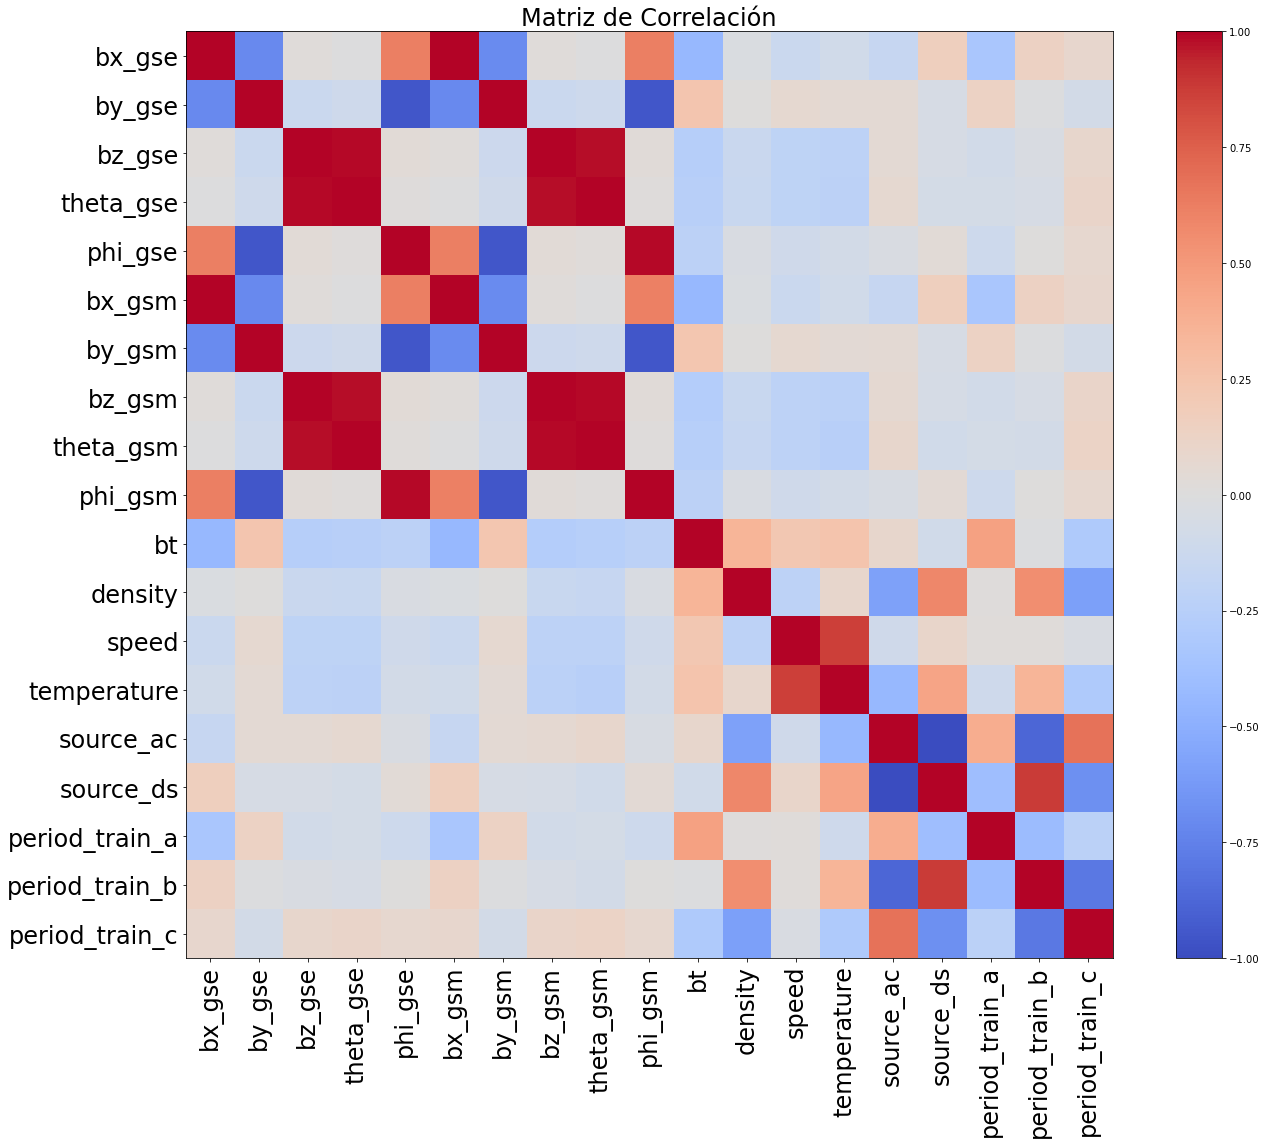

In [4]:
data = dataset.drop({'timedelta'},axis=1)
correlation_matrix = data.corr()
correlation_array = correlation_matrix.to_numpy()
correlation_matrix = np.corrcoef(correlation_array, rowvar=False)
plt.figure(figsize=(20, 16))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.xticks(range(len(data.columns)), data.columns, rotation=90, fontsize=24)
plt.yticks(range(len(data.columns)), data.columns, fontsize=24)

plt.colorbar()
plt.title('Matriz de Correlación', fontsize=24)
plt.tight_layout()
plt.show()

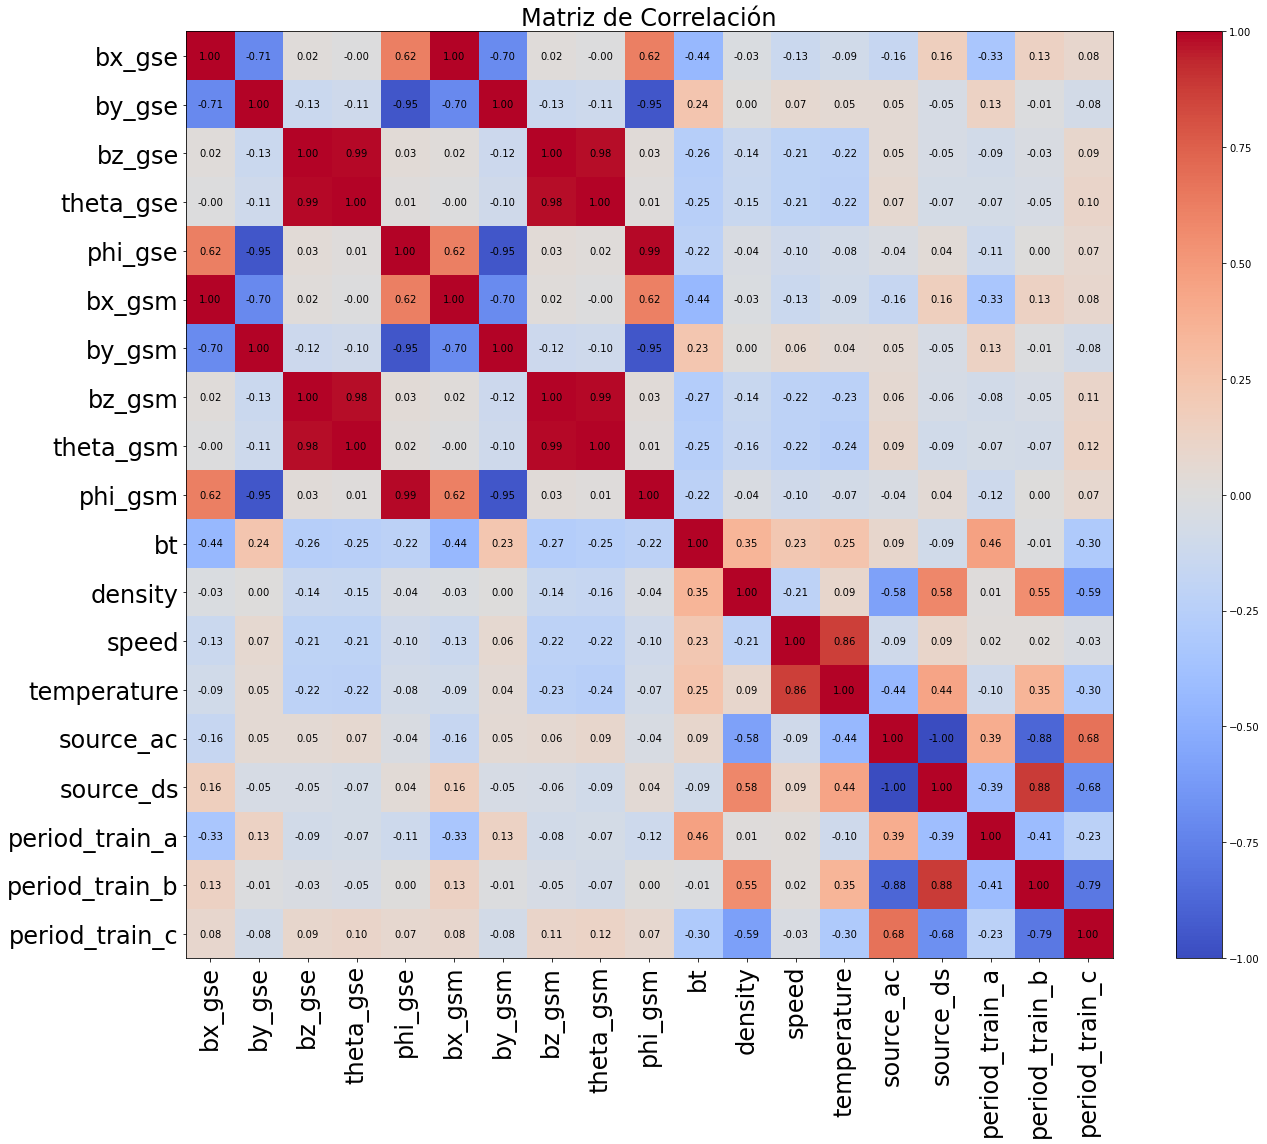

In [5]:
data = dataset.drop({'timedelta'}, axis=1)
correlation_matrix = data.corr()
correlation_array = correlation_matrix.to_numpy()
correlation_matrix = np.corrcoef(correlation_array, rowvar=False)
plt.figure(figsize=(20, 16))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

# Añadir los valores de la matriz de correlación en cada celda
for i in range(len(data.columns)):
    for j in range(len(data.columns)):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black')

plt.xticks(range(len(data.columns)), data.columns, rotation=90, fontsize=24)
plt.yticks(range(len(data.columns)), data.columns, fontsize=24)

plt.colorbar()
plt.title('Matriz de Correlación', fontsize=24)
plt.tight_layout()
plt.show()

In [6]:
# Dividir el dataset en train y test
train_size = int(len(dataset) * 0.8)
train_data = dataset[:train_size]
test_data = dataset[train_size:]

In [7]:
train_data.set_index(['timedelta'])

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source_ac,source_ds,period_train_a,period_train_b,period_train_c
timedelta,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,1,0,1,0,0
0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,1,0,1,0,0
0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,1,0,1,0,0
0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,1,0,1,0,0
0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233 days 22:15:00,1.85,-1.95,0.55,11.46,313.59,1.85,-1.78,0.97,20.74,316.17,2.74,4.46,355.14,28303.0,1,0,0,0,1
1233 days 22:16:00,0.78,-2.77,0.56,10.93,285.72,0.77,-2.58,1.17,23.46,286.73,2.93,4.38,356.59,46966.0,1,0,0,0,1
1233 days 22:17:00,0.53,-2.79,0.64,12.76,280.70,0.52,-2.58,1.26,25.56,281.46,2.91,5.03,356.57,29625.0,1,0,0,0,1


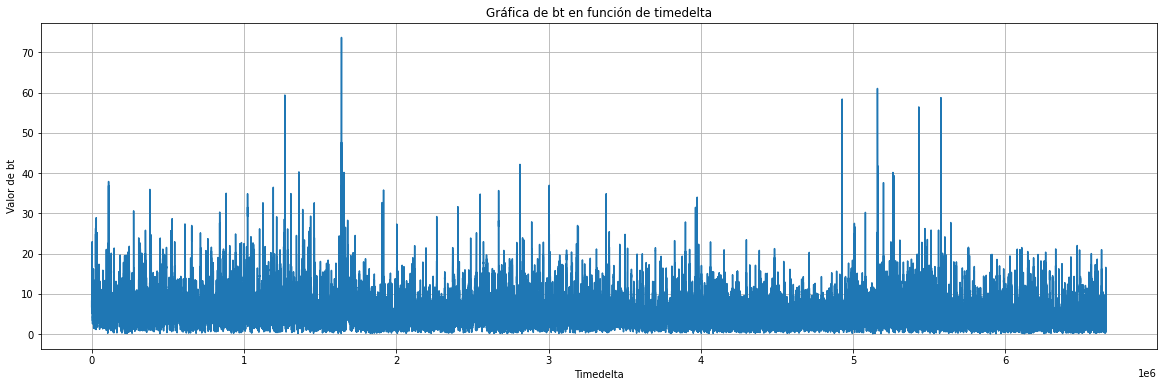

In [8]:
plt.figure(figsize=(20, 6))  # Tamaño de la figura

# Graficar el feature 'bt' en función del índice 'timedelta'
plt.plot(train_data.index, train_data['bt'], linestyle='-')

plt.xlabel('Timedelta')  # Etiqueta del eje x
plt.ylabel('Valor de bt')  # Etiqueta del eje y
plt.title('Gráfica de bt en función de timedelta')  # Título del gráfico

plt.grid(True)  # Agregar una cuadrícula al gráfico
plt.show()  # Mostrar la gráfica

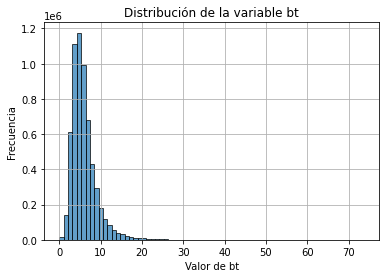

In [9]:
# Graficar el histograma de la variable 'bt'
plt.hist(train_data['bt'], bins=70, edgecolor='black', alpha=0.7)

plt.xlabel('Valor de bt')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
plt.title('Distribución de la variable bt')  # Título del gráfico

plt.grid(True)  # Agregar una cuadrícula al gráfico
plt.show()  # Mostrar el histograma

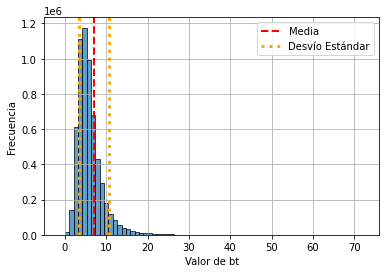

In [10]:
# Datos de la variable 'bt'
bt_values = train_data['bt']
mean_value = 7.069
std_deviation = 3.693

# Graficar el histograma de la variable 'bt'
plt.hist(bt_values, bins=70, edgecolor='black', alpha=0.7)

# Agregar la línea que representa la media
plt.axvline(x=mean_value, color='red', linestyle='dashed', linewidth=2, label='Media')

# Agregar las líneas que representan la desviación estándar
plt.axvline(x=mean_value - std_deviation, color='orange', linestyle='dotted', linewidth=3, label='Desvío Estándar')
plt.axvline(x=mean_value + std_deviation, color='orange', linestyle='dotted', linewidth=3)

plt.xlabel('Valor de bt')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
#plt.title('Distribución de la variable bt')  # Título del gráfico
plt.xlim(left=-5, right=76)
plt.legend()  # Mostrar leyenda con las líneas
plt.grid(True)  # Agregar una cuadrícula al gráfico
plt.show()  # Mostrar el histograma

In [11]:
#Preparo el dataset test para exportarlo
test_data_pd = pd.DataFrame(test_data)#, columns=['bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
#       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
#       'density', 'speed', 'temperature', 'source_ac', 'source_ds', 'period_train_a',
#       'period_train_b', 'period_train_c'])
test_data_pd.reset_index()
test_timedelta = test_data[['timedelta']]
test_timedelta.reset_index(drop=True, inplace = True)
test_data_out = pd.concat([test_timedelta, test_data_pd], axis = 'columns')

test_data = test_data.drop(['timedelta'], axis=1)
train_data = train_data.drop(['timedelta'], axis=1)

In [12]:
# Modificar el feature 'bt' en el dataset de train
feature = 'bt'
anomaly_percentage_train = 0.2
sample_indices_train = train_data.sample(frac=anomaly_percentage_train, random_state=42).index 
num_anomalies_train = int(len(train_data) * anomaly_percentage_train)+1
#train_data.loc[sample_indices_train, feature] = np.random.normal(loc=40, scale=1.5, size=len(sample_indices_train))

train_data.loc[sample_indices_train, feature] = np.random.uniform(low=0, high=100, size=num_anomalies_train)

In [13]:
# Modificar el feature 'bt' en el dataset de test
anomaly_percentage_test = 0.01
sample_indices_test = test_data.sample(frac=anomaly_percentage_test, random_state=42).index
num_anomalies_test = int(len(test_data) * anomaly_percentage_test)+1
#test_data.loc[sample_indices_test, feature] = np.random.normal(loc=40, scale=1.5, size=len(sample_indices_test))

test_data.loc[sample_indices_test, feature] = np.random.uniform(low=0, high=100, size=len(sample_indices_test))

In [14]:
# Agregar el feature "class" en el dataset
train_data['class'] = 0
train_data.loc[sample_indices_train, 'class'] = 1
test_data['class'] = 0
test_data.loc[sample_indices_test, 'class'] = 1

In [15]:
count = (test_data['class'] == 1).sum()
count1 = (test_data['class'] == 0).sum()
print(f'En el dataset TEST el número de anomalias es {count} y {count1} son valores normales')

En el dataset TEST el número de anomalias es 15142 y 1499075 son valores normales


In [ ]:
#test_data_pd = pd.DataFrame(test_data, columns=['bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
#       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
#       'density', 'speed', 'temperature', 'source_ac', 'source_ds', 'period_train_a',
#       'period_train_b', 'period_train_c'])

In [16]:
test_timedelta.index = test_data_pd.index
test_data_out = pd.concat([test_timedelta, test_data_pd], axis = 'columns')

In [17]:
test_data_out

,timedelta,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,...,phi_gsm,bt,density,speed,temperature,source_ac,source_ds,period_train_a,period_train_b,period_train_c
6661340,1233 days 22:20:00,1233 days 22:20:00,1.17,-2.54,0.65,13.16,294.66,1.16,-2.33,1.21,...,296.50,2.87,4.71,353.47,33302.0,1,0,0,0,1
6661341,1233 days 22:21:00,1233 days 22:21:00,1.13,-2.66,-0.17,-3.45,292.94,1.12,-2.63,0.43,...,293.04,2.89,5.12,349.25,41200.0,1,0,0,0,1
6661342,1233 days 22:22:00,1233 days 22:22:00,0.63,-2.98,-0.21,-3.86,281.96,0.63,-2.95,0.47,...,281.98,3.05,3.55,351.36,34041.0,1,0,0,0,1
6661343,1233 days 22:23:00,1233 days 22:23:00,1.76,-2.01,0.16,3.42,311.17,1.75,-1.92,0.61,...,312.32,2.67,4.81,353.56,25111.0,1,0,0,0,1
6661344,1233 days 22:24:00,1233 days 22:24:00,1.61,-2.20,0.16,3.31,306.17,1.60,-2.11,0.65,...,307.25,2.73,4.42,348.54,57336.0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8392315,2435 days 23:55:00,2435 days 23:55:00,-1.18,2.00,-3.92,-59.28,120.51,-1.17,2.98,-3.23,...,111.48,4.56,4.64,348.73,23368.0,1,0,0,0,1
8392316,2435 days 23:56:00,2435 days 23:56:00,-1.34,2.12,-3.83,-56.78,122.23,-1.33,3.08,-3.12,...,113.45,4.58,4.27,346.36,26497.0,1,0,0,0,1
8392317,2435 days 23:57:00,2435 days 23:57:00,-1.62,2.33,-3.63,-51.98,124.76,-1.61,3.22,-2.87,...,116.58,4.61,3.95,344.12,27050.0,1,0,0,0,1
8392318,2435 days 23:58:00,2435 days 23:58:00,-2.27,2.48,-3.22,-43.81,132.50,-2.26,3.25,-2.44,...,124.81,4.65,2.81,338.52,33257.0,1,0,0,0,1


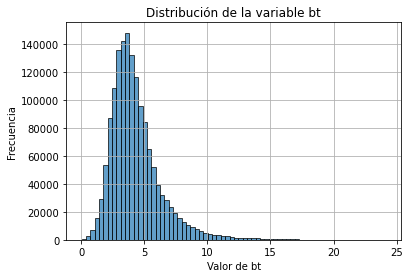

In [18]:
# Graficar el histograma de la variable 'bt'
plt.hist(test_data_out['bt'], bins=70, edgecolor='black', alpha=0.7)

plt.xlabel('Valor de bt')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
plt.title('Distribución de la variable bt')  # Título del gráfico

plt.grid(True)  # Agregar una cuadrícula al gráfico
plt.show()  # Mostrar el histograma

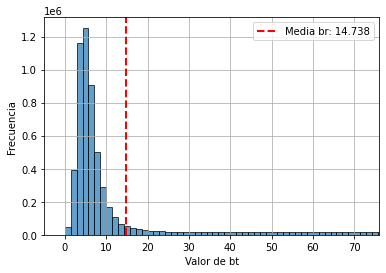

In [19]:
bt_values = train_data['bt']

# Graficar el histograma de la variable 'bt'
plt.hist(bt_values, bins=70, edgecolor='black', alpha=0.7)

# Calcular las medias 1 y 2
media1 = 14.738
#media2 = 40

# Graficar líneas verticales para las medias
plt.axvline(x=media1, color='r', linestyle='dashed', linewidth=2, label=f'Media br: {media1}')
#plt.axvline(x=media2, color='g', linestyle='dashed', linewidth=2, label=f'Media anomalías: {media2}')

plt.xlabel('Valor de bt')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
#plt.title('Distribución de la variable bt')  # Título del gráfico
plt.xlim(left=-5, right=76)

plt.grid(True)  # Agregar una cuadrícula al gráfico
plt.legend()    # Mostrar leyenda con las medias
plt.show()      # Mostrar el histograma

In [49]:
bt_values.describe()

count    6.056864e+06
mean     1.474287e+01
std      2.203057e+01
min      1.176917e-06
25%      4.190000e+00
50%      5.940000e+00
75%      9.890000e+00
max      9.999999e+01
Name: bt, dtype: float64

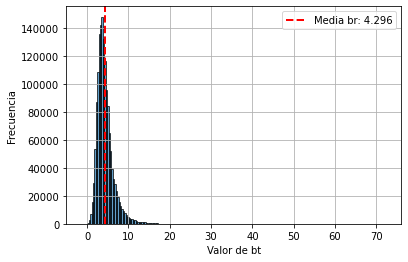

In [20]:
bt_values = test_data_out['bt']

# Graficar el histograma de la variable 'bt'
plt.hist(bt_values, bins=70, edgecolor='black', alpha=0.7)

# Calcular las medias 1 y 2
media1 = 4.296
media2 = 40

# Graficar líneas verticales para las medias
plt.axvline(x=media1, color='r', linestyle='dashed', linewidth=2, label=f'Media br: {media1}')
#plt.axvline(x=media2, color='g', linestyle='dashed', linewidth=2, label=f'Media anomalías: {media2}')

plt.xlabel('Valor de bt')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
#plt.title('Distribución de la variable bt')  # Título del gráfico
plt.xlim(left=-5, right=76)

plt.grid(True)  # Agregar una cuadrícula al gráfico
plt.legend()    # Mostrar leyenda con las medias
plt.show()      # Mostrar el histograma

In [21]:
bt_values.describe()

count    1.514217e+06
mean     4.296276e+00
std      2.038075e+00
min      3.000000e-02
25%      2.980000e+00
50%      3.890000e+00
75%      5.100000e+00
max      2.416000e+01
Name: bt, dtype: float64

In [22]:
# Separar las features del dataset y la variable de salida "class"
X_train = train_data.drop('class', axis=1).values
y_train = train_data['class'].values
X_test = test_data.drop('class', axis=1).values
y_test = test_data['class'].values

In [23]:
X_train = pd.DataFrame(X_train, columns=['bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
       'density', 'speed', 'temperature', 'source_ac', 'source_ds', 'period_train_a',
       'period_train_b', 'period_train_c'])
y_train = pd.DataFrame(y_train, columns = ['Class'])

In [108]:
# Aplicar PCA a train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

componentes = 9
pca = PCA(n_components = componentes)
X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)

X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)
data_train_X = X_train_pca
#data_test_X = X_test_pca  

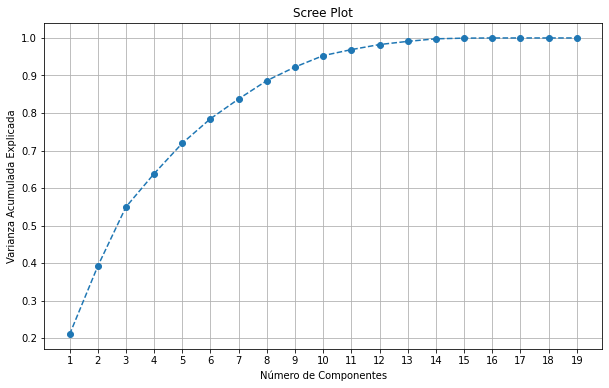

In [104]:
# Scree Plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, componentes + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Scree Plot')
plt.xticks(range(1, componentes + 1))
plt.grid(True)
plt.show()

### RBM

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [135]:
# Definir la arquitectura de la RBM
def weighted_mean_squared_error(y_true, y_pred):
    weights = K.cast(K.not_equal(y_true, 0), K.floatx())
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)  

visible = Input(shape=(data_train_X.shape[1],))
#hidden = Dense(64, activation='sigmoid')(visible)
hidden = Dense(16, activation='sigmoid', kernel_regularizer=l1(0.001))(visible)
hidden = Dropout(0.5)(hidden)
hidden = Dense(12, activation='sigmoid', kernel_regularizer=l1(0.001))(visible)
#hidden = Dense(32, activation='sigmoid')(visible)
hidden = Dropout(0.5)(hidden)
visible_recon = Dense(data_train_X.shape[1], activation='sigmoid')(hidden)

# Crear el modelo de RBM
rbm_model = Model(inputs=visible, outputs=visible_recon)
rbm_model.compile(optimizer=Adam(learning_rate=0.0001), loss=weighted_mean_squared_error)

In [136]:
start_time = time.time()
hist_rbm = rbm_model.fit(data_train_X, data_train_X, epochs=50, batch_size=320, validation_split=0.1)
end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

Epoch 1/50
17035/17035 [==============================] - 23s 1ms/step - loss: 1.8440 - val_loss: 1.4860
Epoch 2/50
17035/17035 [==============================] - 23s 1ms/step - loss: 1.7089 - val_loss: 1.4510
Epoch 3/50
17035/17035 [==============================] - 26s 2ms/step - loss: 1.6777 - val_loss: 1.4228
Epoch 4/50
17035/17035 [==============================] - 35s 2ms/step - loss: 1.6578 - val_loss: 1.3801
Epoch 5/50
17035/17035 [==============================] - 35s 2ms/step - loss: 1.6402 - val_loss: 1.3452
Epoch 6/50
17035/17035 [==============================] - 34s 2ms/step - loss: 1.6229 - val_loss: 1.3296
Epoch 7/50
17035/17035 [==============================] - 38s 2ms/step - loss: 1.6106 - val_loss: 1.3160
Epoch 8/50
17035/17035 [==============================] - 35s 2ms/step - loss: 1.6024 - val_loss: 1.3048
Epoch 9/50
17035/17035 [==============================] - 36s 2ms/step - loss: 1.5978 - val_loss: 1.2934
Epoch 10/50
17035/17035 [==============================

In [137]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
componentes = 9
pca = PCA(n_components = componentes)
X_test_pca = pca.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)
data_test_X = X_test_pca

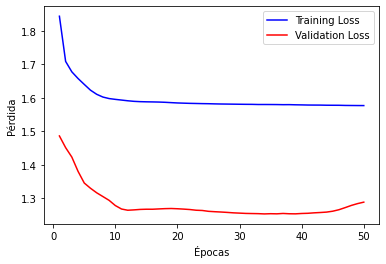

47320/47320 [==============================] - 44s 923us/step


In [138]:
import matplotlib.pyplot as plt
# Obtener los valores de pérdida y val_loss del historial
loss = hist_rbm.history['loss']
val_loss = hist_rbm.history['val_loss']
# Crear un arreglo con los números de épocas
epochs = range(1, len(loss) + 1)
# Graficar la pérdida y val_loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
#plt.title('Pérdida y Val_loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
#X_train_pred = rbm_model.predict(data_train_X)
X_test_pred_RBM = rbm_model.predict(data_test_X)

Threshold =  4.0


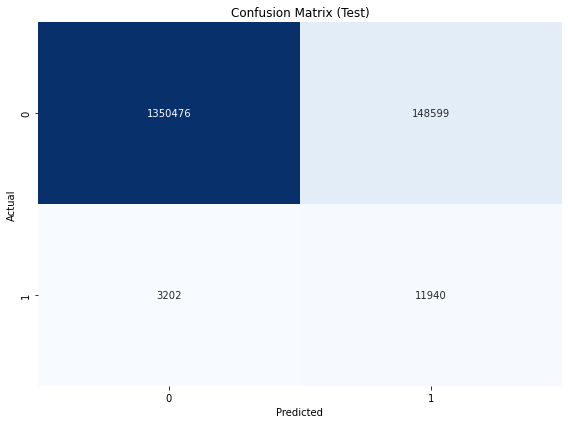

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.90      0.95   1499075
           1       0.07      0.79      0.14     15142

    accuracy                           0.90   1514217
   macro avg       0.54      0.84      0.54   1514217
weighted avg       0.99      0.90      0.94   1514217



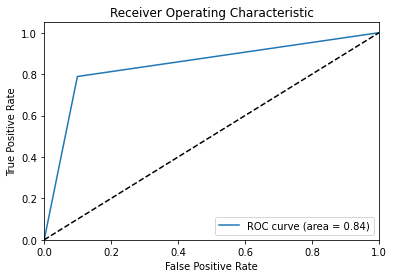

AUC: 0.8447040358549109
Threshold =  4.0


In [31]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)

# Calcular la matriz de confusión
y_test_pred_RBM = np.where(np.linalg.norm(data_test_X - X_test_pred_RBM, axis=1) > threshold, 1, 0)

cm_test = confusion_matrix(y_test, y_test_pred_RBM)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Calcular el classification report
classification_test = classification_report(y_test, y_test_pred_RBM)
print('Classification Report (Test):\n', classification_test)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_RBM)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print('AUC:', roc_auc)
print("Threshold = ", threshold)

In [32]:
name = input("Ingrese el nombre de los archivos a generar sin extención: ")
# serializa el modelo para JSON
model_json = rbm_model.to_json()
with open(f"{name}.json", "w") as json_file:
    json_file.write(model_json)
#serializan los pesos (weights) para HDF5
rbm_model.save_weights(f"{name}.h5")
print("Modelo guardado en el PC")

Modelo guardado en el PC


### LSTM Autoencoder

In [128]:
# Agregar una tercera dimensión al dataset
X_train_3d = X_train_pca.reshape(X_train_pca.shape[0], 1, X_train_pca.shape[1])
#X_test_3d = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])

In [129]:
# Construir el modelo del autoencoder con LSTM
def weighted_mean_squared_error(y_true, y_pred):
    weights = K.cast(K.not_equal(y_true, 0), K.floatx())
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)   


input_dim = X_train_3d.shape[2]
timesteps = X_train_3d.shape[1]

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(32, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(8, activation='relu', return_sequences=False)(encoded) 
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(8, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss=weighted_mean_squared_error)

In [130]:
# Entrenar el modelo del autoencoder
start_time = time.time()
hist = autoencoder.fit(X_train_3d, X_train_3d, epochs=25, batch_size=320, validation_split=0.1)
end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

Epoch 1/25
17035/17035 [==============================] - 232s 13ms/step - loss: 0.1725 - val_loss: 0.0630
Epoch 2/25
17035/17035 [==============================] - 161s 9ms/step - loss: 0.0596 - val_loss: 0.0542
Epoch 3/25
17035/17035 [==============================] - 163s 10ms/step - loss: 0.0368 - val_loss: 0.0530
Epoch 4/25
17035/17035 [==============================] - 160s 9ms/step - loss: 0.0332 - val_loss: 0.0494
Epoch 5/25
17035/17035 [==============================] - 169s 10ms/step - loss: 0.0316 - val_loss: 0.0360
Epoch 6/25
17035/17035 [==============================] - 160s 9ms/step - loss: 0.0278 - val_loss: 0.0336
Epoch 7/25
17035/17035 [==============================] - 168s 10ms/step - loss: 0.0179 - val_loss: 0.0120
Epoch 8/25
17035/17035 [==============================] - 193s 11ms/step - loss: 0.0062 - val_loss: 0.0128
Epoch 9/25
17035/17035 [==============================] - 176s 10ms/step - loss: 0.0050 - val_loss: 0.0132
Epoch 10/25
17035/17035 [===============

In [132]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
componentes = 9
pca = PCA(n_components = componentes)
X_test_pca = pca.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)
data_test_X = X_test_pca
X_test_3d = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])

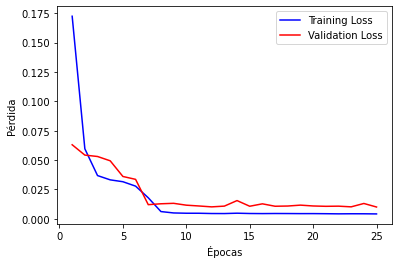

47320/47320 [==============================] - 100s 2ms/step


In [134]:
# Obtener los valores de pérdida y val_loss del historial
loss = hist.history['loss']
val_loss = hist.history['val_loss']
# Crear un arreglo con los números de épocas
epochs = range(1, len(loss) + 1)
# Graficar la pérdida y val_loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
#plt.title('Pérdida y Val_loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
X_test_pred = autoencoder.predict(X_test_3d)

Threshold =  10.0


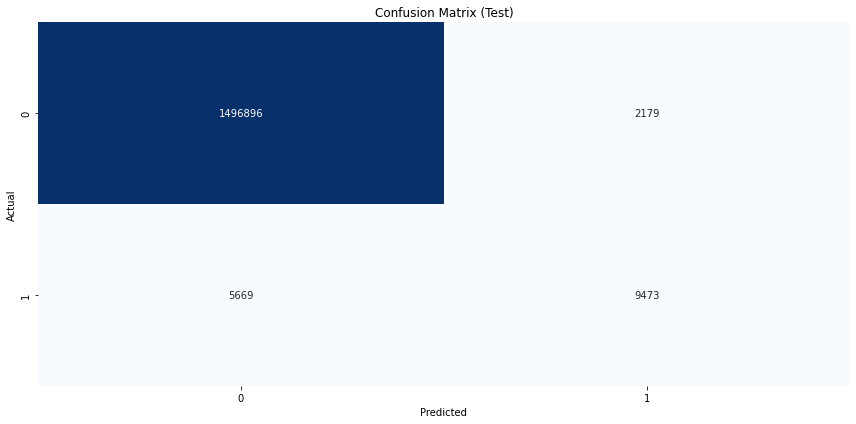

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1499075
           1       0.81      0.63      0.71     15142

    accuracy                           0.99   1514217
   macro avg       0.90      0.81      0.85   1514217
weighted avg       0.99      0.99      0.99   1514217



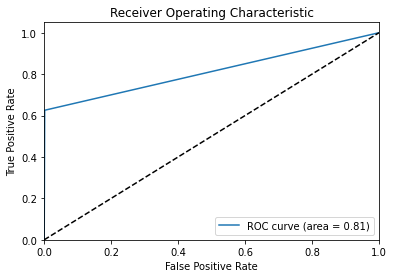

AUC: 0.8120786603021937
Threshold =  10.0


In [67]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)
# Calcular la matriz de confusión
y_test_pred = np.where(np.linalg.norm(X_test_3d - X_test_pred, axis=(1, 2)) > threshold, 1, 0)
cm_test = confusion_matrix(y_test, y_test_pred)
# Visualizar la matriz de confusión
import seaborn as sns # borrar
plt.figure(figsize=(12, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()
# Calcular el classification report
classification_test = classification_report(y_test, y_test_pred)
print('Classification Report (Test):\n', classification_test)

# Calcular la curva ROC y el AUC
#fpr, tpr, thresholds = roc_curve(y_test, y_test_pred[:,10])
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print('AUC:', roc_auc)
print("Threshold = ", threshold)

Se guarda los dataset de train y test y seguidamente el modelo entrenado

In [69]:
# guardo el dataset train
X_train.to_csv('X_train.csv')
y_train_pd = pd.DataFrame(y_train, columns = ['class'])
y_train_pd.to_csv('y_train.csv')
print("Se guardó dataset de train con el nombre X_train.csv e y_train.csv")
# guardo el dataset test
test_data_out.to_csv('test_data.csv')
y_test_pd = pd.DataFrame(y_test, columns = ['class'])
y_test_pd.to_csv('y_test.csv')
print("Se guardó dataset de test con el nombre test_data_LSTM.csv")

Se guardó dataset de train con el nombre X_train.csv e y_train.csv
Se guardó dataset de test con el nombre test_data_LSTM.csv


In [73]:
name = input("Ingrese el nombre de los archivos a generar sin extención: ")
# serializa el modelo para JSON
model_json = autoencoder.to_json()
with open(f"{name}.json", "w") as json_file:
    json_file.write(model_json)
#serializan los pesos (weights) para HDF5
autoencoder.save_weights(f"{name}.h5")
print("Modelo guardado en el PC")

Modelo guardado en el PC


### Isolation Forest

In [110]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
componentes = 9
pca = PCA(n_components = componentes)
X_test_pca = pca.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)
data_test_X = X_test_pca

i = 3


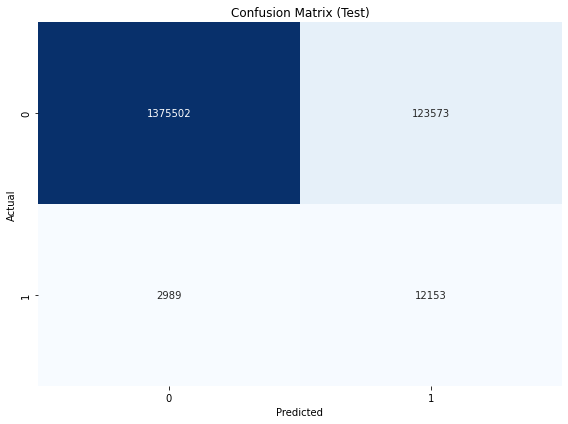

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.92      0.96   1499075
           1       0.09      0.80      0.16     15142

    accuracy                           0.92   1514217
   macro avg       0.54      0.86      0.56   1514217
weighted avg       0.99      0.92      0.95   1514217



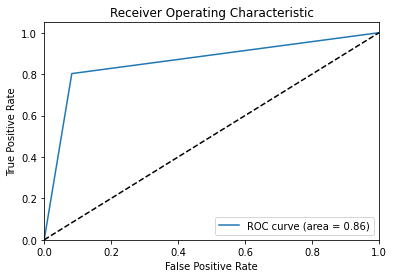

AUC: 0.8600846002483464


In [127]:
for i in range(3,4):
    #Modelo
    model_if = IsolationForest(n_estimators=112 , contamination=0.2, random_state=0)
    #Entreno el modelo
    model_if.fit(data_train_X,data_train_X)
    #Guardo el modelo.
    #joblib.dump(model_if, 'model_if.joblib')
    # serializa el modelo para JSON
    #model_json = model_if.to_json()
    #with open("model_if.json", "w") as json_file:
    #    json_file.write(model_json)
    #serializan los pesos (weights) para HDF5
    #model_if.save_weights("model_if.h5")
    #print("Modelo guardado localmente")
    print("i =", i)
    X_test_pred_if = model_if.predict(data_test_X)
    X_test_pred_if = np.where(X_test_pred_if == 1, 0, np.where(X_test_pred_if == -1, 1, X_test_pred_if))
    threshold = 5

    # Calcular la matriz de confusión
    #y_test_pred_if = np.where(np.linalg.norm(data_test_X - X_test_pred_if, axis=1) > threshold, 1, 0)

    cm_test = confusion_matrix(y_test, X_test_pred_if)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Calcular el classification report
    classification_test = classification_report(y_test, X_test_pred_if)
    print('Classification Report (Test):\n', classification_test)

    # Calcular la curva ROC y el AUC
    fpr, tpr, thresholds = roc_curve(y_test, X_test_pred_if)
    roc_auc = auc(fpr, tpr)
    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Imprimir el AUC
    print('AUC:', roc_auc)


In [ ]:
X_test_pred_if = model_if.predict(data_test_X)

In [95]:
 X_test_pred_if = np.where(X_test_pred_if == 1, 0, np.where(X_test_pred_if == -1, 1, X_test_pred_if))

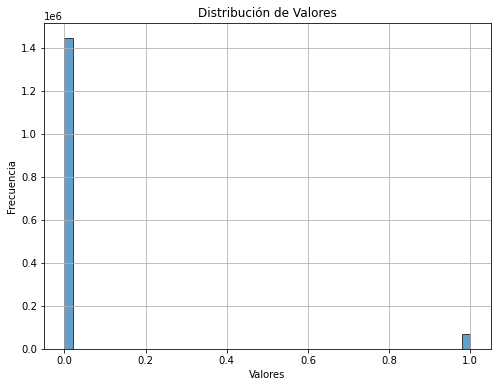

In [96]:
plt.figure(figsize=(8, 6))  # Tamaño de la figura

# Generar el histograma de la distribución de valores
plt.hist(X_test_pred_if, bins=50, edgecolor='black', alpha=0.7)

plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores')
plt.grid(True)
plt.show()

In [97]:
count_0 = np.bincount(y_test == 0)[0]
count_1 = np.bincount(y_test == 1)[0]

print(f"Cantidad de 0: {count_0}")
print(f"Cantidad de 1: {count_1}")

Cantidad de 0: 15142
Cantidad de 1: 1499075


Threshold =  50.0


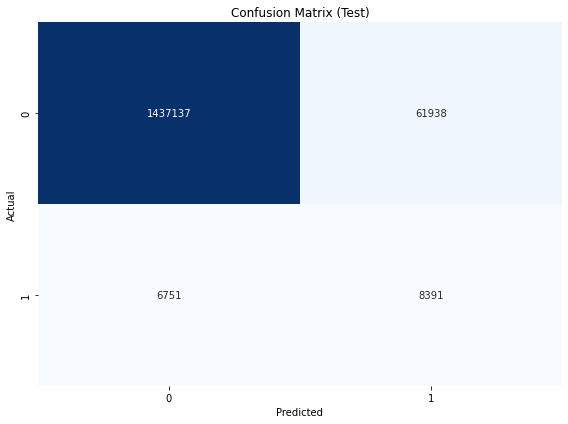

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1499075
           1       0.12      0.55      0.20     15142

    accuracy                           0.95   1514217
   macro avg       0.56      0.76      0.59   1514217
weighted avg       0.99      0.95      0.97   1514217



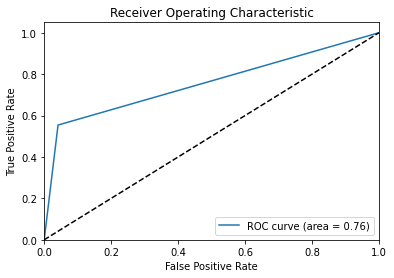

AUC: 0.7564182648026777
Threshold =  50.0


In [99]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)

# Calcular la matriz de confusión
#y_test_pred_if = np.where(np.linalg.norm(data_test_X - X_test_pred_if, axis=1) > threshold, 1, 0)

cm_test = confusion_matrix(y_test, X_test_pred_if)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Calcular el classification report
classification_test = classification_report(y_test, X_test_pred_if)
print('Classification Report (Test):\n', classification_test)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, X_test_pred_if)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print('AUC:', roc_auc)
print("Threshold = ", threshold)

Se guarda el dataset de salida

In [ ]:
# Agregar la nueva columna al final del ndarray original
y_test_pred_if = y_test_pred_if[:, np.newaxis]
pd_predictions = np.hstack((X_test[:,:-5], y_test_pred_if))

pd_predictions = pd.DataFrame(pd_predictions, columns = ['bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
       'density', 'speed', 'temperature','class'] )
pd_predictions['class'] = pd_predictions['class'].astype(int)
predictions_class_pd = pd.concat([test_timedelta, pd_predictions], axis = 1 , join = "inner")

In [ ]:
anomalies = predictions_class_pd.loc[predictions_class_pd['class'] == 1.0,['timedelta']]
output = predictions_class_pd[predictions_class_pd['timedelta'].isin(anomalies['timedelta'])]
output = output.round(3)


In [ ]:
anomalies

In [ ]:
pd_predictions.head()

In [ ]:
predictions_class_pd.head()

In [ ]:
output.head()

Se guardan los datasets

In [ ]:
# guardo el dataset train
X_train.to_csv('X_train.csv')
y_train_pd = pd.DataFrame(y_train, columns = ['class'])
y_train_pd.to_csv('y_train.csv')
print("Se guardó dataset de train con el nombre X_train.csv e y_train.csv")
# guardo el dataset test
test_data_out.to_csv('test_data.csv')
y_test_pd = pd.DataFrame(y_test, columns = ['class'])
y_test_pd.to_csv('y_test.csv')
print("Se guardó dataset de test con el nombre test_data_LSTM.csv")